# Modèle DL pour classification (RNN et LSTM)

## Préparations des données

### Chargement des données

In [1]:
import numpy as np
import pandas as pd

def import_data():
    x_train = pd.read_csv(r"Dataset\DBP\x_train.csv", index_col=False)
    y_train = pd.read_csv(r"Dataset\DBP\y_train.csv", index_col=False)
    x_test = pd.read_csv(r"Dataset\DBP\x_test.csv", index_col=False)
    y_test = pd.read_csv(r"Dataset\DBP\y_test.csv", index_col=False)

    x_train = x_train['text'].astype(str)
    y_train = y_train['l3']
    x_test = x_test['text'].astype(str)
    y_test = y_test['l3']

    print("Taille du dataset d'entraînement :", x_train.shape[0])
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = import_data()

# Fusion des ensembles d'entraînement et de test
x = pd.concat([x_train, x_test], ignore_index=True)
y = pd.concat([y_train, y_test], ignore_index=True)

# Création d'un DataFrame combiné
df = pd.DataFrame({'text': x, 'l3': y})

# Mélange et sous-échantillonnage
df_filtered = df.sample(n=100000, random_state=42).reset_index(drop=True)

# Séparation des colonnes
x = df_filtered['text']
y = df_filtered['l3']


Taille du dataset d'entraînement : 274224


### Tokénisation

In [2]:
import pickle
from nltk.tokenize import TreebankWordTokenizer

x = x.tolist()

x2 = [i.split() for i in x]

word_tokenizer = TreebankWordTokenizer()
tokens = [word_tokenizer.tokenize(sent) for sent in x]

print(len(tokens))
print(x2[0])
print(tokens[0])

100000
['saint', 'irenarch', 'recluse', 'orthodox', 'church', 'hermit', 'born', 'peasant', 'family', 'village', 'district', 'russia', 'baptism', 'receive', 'name', 'thirtieth', 'year', 'tonsure', 'monk', 'st', 'monastery', 'fervently', 'labor', 'monastic', 'church', 'night', 'slept', 'ground', 'take', 'pity', 'vagrant', 'st', 'give', 'boot', 'time', 'go', 'barefoot', 'snow', 'mystic', 'visionary', 'death', 'many', 'physical', 'psychological', 'spiritual', 'touch', 'eastern', 'orthodox', 'church', 'companion', 'hairy']
['saint', 'irenarch', 'recluse', 'orthodox', 'church', 'hermit', 'born', 'peasant', 'family', 'village', 'district', 'russia', 'baptism', 'receive', 'name', 'thirtieth', 'year', 'tonsure', 'monk', 'st', 'monastery', 'fervently', 'labor', 'monastic', 'church', 'night', 'slept', 'ground', 'take', 'pity', 'vagrant', 'st', 'give', 'boot', 'time', 'go', 'barefoot', 'snow', 'mystic', 'visionary', 'death', 'many', 'physical', 'psychological', 'spiritual', 'touch', 'eastern', 'or

On remarque que le preprocessing à permit de faciliter la tokénisation car il suffit de faire .split() pour obtenir un dataset tokénisé

### Embedding

#### Création du modèle d'embedding 

In [3]:
from gensim.models import Word2Vec

word2vec = Word2Vec(sentences=tokens, vector_size=200, window=5, min_count=1, workers=4,epochs=10)
word2vec.save(r"Model/Classification/Précis/word2vec.model")

#### Vectorisation et padding

In [4]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def vectorization(tokenized_sentences, word2vec_model):
    padded_sequences = []

    for tokens in tokenized_sentences:
        vecs = []
        for word in tokens:
            if word in word2vec_model.wv:
                vecs.append(word2vec_model.wv[word])
            else:
                vecs.append(np.zeros(word2vec_model.vector_size))
        padded_sequences.append(vecs)
    max_len = 200
    padded = pad_sequences(padded_sequences, maxlen=max_len ,padding='post', dtype='float32')
    return padded, max_len


x_padded, max_len = vectorization(tokens, word2vec)


#### Label

In [5]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Étape 1 : encoder les labels textuels
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Convertit ['Congressman', 'Senator', ...] → [0, 1, ...]

# Optionnel : afficher les correspondances
print(dict(zip(le.classes_, le.transform(le.classes_))))


{'AcademicJournal': 0, 'AdultActor': 1, 'Airline': 2, 'Airport': 3, 'Album': 4, 'AmateurBoxer': 5, 'Ambassador': 6, 'AmericanFootballPlayer': 7, 'Amphibian': 8, 'AnimangaCharacter': 9, 'Anime': 10, 'Arachnid': 11, 'Architect': 12, 'ArtificialSatellite': 13, 'ArtistDiscography': 14, 'Astronaut': 15, 'AustralianFootballTeam': 16, 'AustralianRulesFootballPlayer': 17, 'AutomobileEngine': 18, 'BadmintonPlayer': 19, 'Band': 20, 'Bank': 21, 'Baronet': 22, 'BaseballLeague': 23, 'BaseballPlayer': 24, 'BaseballSeason': 25, 'BasketballLeague': 26, 'BasketballPlayer': 27, 'BasketballTeam': 28, 'BeachVolleyballPlayer': 29, 'BeautyQueen': 30, 'BiologicalDatabase': 31, 'Bird': 32, 'Bodybuilder': 33, 'Brewery': 34, 'Bridge': 35, 'BroadcastNetwork': 36, 'BusCompany': 37, 'BusinessPerson': 38, 'CanadianFootballTeam': 39, 'Canal': 40, 'Canoeist': 41, 'Cardinal': 42, 'Castle': 43, 'Cave': 44, 'Chef': 45, 'ChessPlayer': 46, 'ChristianBishop': 47, 'ClassicalMusicArtist': 48, 'ClassicalMusicComposition': 49,

Pas assez de mémoire

### Split train & test

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_padded, y_encoded, test_size=0.2, random_state=42)

## Préparation du model

In [7]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

num_classes = len(np.unique(y))  # nombre de classes

model = Sequential()
model.add(Masking(mask_value=0., input_shape=(max_len, word2vec.vector_size)))
model.add(LSTM(128))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))  # nombre correct de classes

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=1,
    restore_best_weights=True
)



c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Entrainnement du model

In [8]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=10,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 608s 242ms/step - accuracy: 0.5683 - loss: 1.9387 - val_accuracy: 0.8651 - val_loss: 0.5048
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 616s 246ms/step - accuracy: 0.8847 - loss: 0.4140 - val_accuracy: 0.8851 - val_loss: 0.4192
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 621s 248ms/step - accuracy: 0.9100 - loss: 0.3122 - val_accuracy: 0.8900 - val_loss: 0.4044
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 621s 248ms/step - accuracy: 0.9260 - loss: 0.2510 - val_accuracy: 0.8950 - val_loss: 0.3922
Epoch 5/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 631s 252ms/step - accuracy: 0.9395 - loss: 0.2007 - val_accuracy: 0.8936 - val_loss: 0.3991


## Evaluation du model

#### Metric durant entrainnement

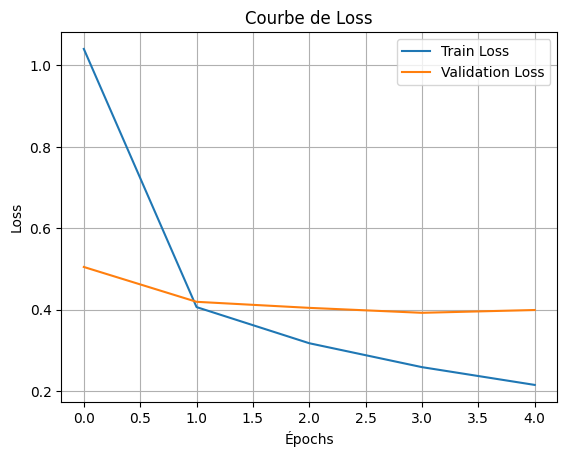

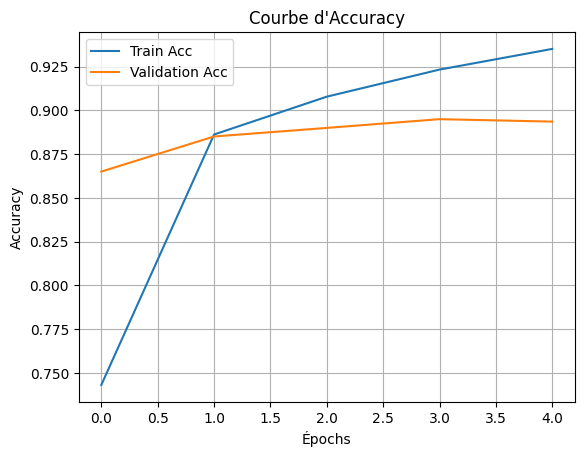

In [9]:
import matplotlib.pyplot as plt

# Affichage de la loss
def graph_loss(history):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title("Courbe de Loss")
    plt.xlabel("Épochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()
    return None

# Affichage de l'accuracy (ou autre métrique selon ton cas)
def graph_accuracy(history):
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Validation Acc')
    plt.legend()
    plt.title("Courbe d'Accuracy")
    plt.xlabel("Épochs")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()
    return None

graph_loss(history)
graph_accuracy(history)

#### Matrice de confusion

In [10]:
print(x_test.shape)
print(y_test.shape)

(20000, 200, 200)
(20000,)


625/625 ━━━━━━━━━━━━━━━━━━━━ 79s 127ms/step
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       141
           1       0.96      0.67      0.79        72
           2       0.95      0.96      0.95       161
           3       0.97      0.96      0.97       142
           4       0.94      0.90      0.92       163
           5       0.85      1.00      0.92        22
           6       0.78      0.75      0.77        24
           7       0.98      0.85      0.91       139
           8       0.90      0.90      0.90       178
           9       0.74      1.00      0.85        14
          10       0.76      0.81      0.79        81
          11       0.88      0.78      0.83       174
          12       0.93      0.92      0.93       161
          13       0.96      0.95      0.95       128
          14       0.93      0.92      0.92       164
          15       0.86      0.97      0.91        37
          16       0.86      0.72    

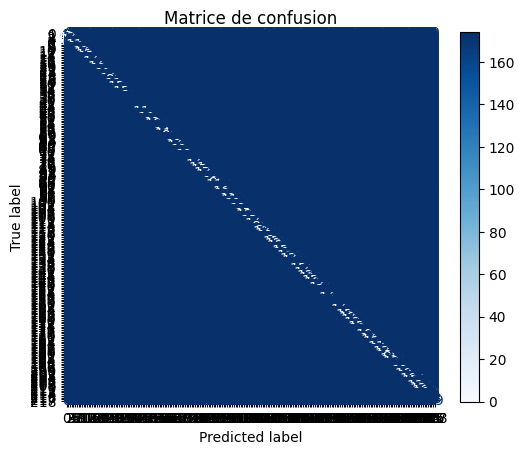

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def show_confusion_matrix(x_test, y_test, model):
    y_pred = model.predict(x_test)
    y_pred_classes = y_pred.argmax(axis=1)

    print(classification_report(y_test, y_pred_classes))

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title("Matrice de confusion")
    plt.show()

# Utilisation
show_confusion_matrix(x_test, y_test, model)


#### Sauvegarder le model

In [12]:
model.save(r"Model/Classification/Précis/model_dl.keras")